<a href="https://colab.research.google.com/github/travislatchman/Face-Recognition-Classification-Algorithms/blob/main/eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import scipy.io

import random


In [ ]:
# set random seed for reproducibility
np.random.seed(42)


In [ ]:
# import the file YaleB-32x32.mat
YaleB = scipy.io.loadmat('YaleB_32x32.mat')


In [ ]:
# Access variables
fea = YaleB['fea']  # every row is a face
gnd = YaleB['gnd'].ravel()  # labels


In [ ]:
# define range of m values to try
m_values = [10, 20, 30, 40, 50]


In [ ]:
# initialize variables to store classification errors for each value of m
classification_errors = []


In [ ]:
# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # apply PCA to training data
    pca = PCA(n_components=100)
    pca.fit(train_data)
    train_data_pca = pca.transform(train_data)
    test_data_pca = pca.transform(test_data)
    # train k-NN algorithm on PCA-transformed training data
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_data_pca, train_labels)

    # predict test set labels
    pred_labels = knn.predict(test_data_pca)

    # calculate classification error rate
    classification_error_rate = np.sum(pred_labels != test_labels) / len(test_labels) * 100

    # store classification error rate
    classification_errors.append(classification_error_rate)


In [ ]:
print(classification_errors)


[59.63618485742379, 46.43288996372431, 39.71742543171114, 34.22818791946309, 30.35019455252918]


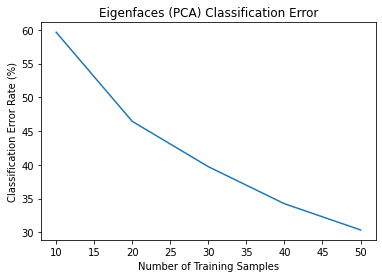

In [ ]:
# plot Classification Error Rate vs Number of Trainings Samples curves
plt.plot(m_values, classification_errors)
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('Eigenfaces (PCA) Classification Error')
plt.show()


### PCA built-in function with whitening

In [ ]:

# define range of m values to try
m_values = [10, 20, 30, 40, 50]

# initialize variables to store classification errors for each value of m
classification_errors = []

# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # apply PCA to training data
    pca = PCA(n_components=100, svd_solver='randomized', whiten=True)
    pca.fit(train_data)
    train_pca = pca.transform(train_data)
    test_pca = pca.transform(test_data)

    # train k-NN classifier on training data and compute classification error on test data
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_pca, train_labels)
    predicted_labels = knn.predict(test_pca)
    classification_errors.append(
        np.sum(predicted_labels != test_labels) / test_labels.shape[0] * 100)


In [ ]:
classification_errors


[23.35299901671583,
 15.235792019347038,
 11.852433281004709,
 10.40268456375839,
 9.33852140077821]

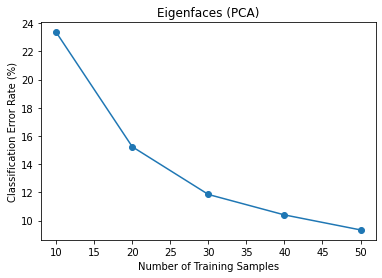

In [ ]:

# plot classification errors vs. number of training samples
plt.plot(m_values, classification_errors, '-o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('Eigenfaces (PCA)')
plt.show()


### PCA/Eigenfaces from scratch

In [ ]:
# define range of m values to try
m_values = [10, 20, 30, 40, 50]

# initialize variables to store classification errors for each value of m
classification_errors = []


In [ ]:
# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Calculate average face and normalize training and test faces
    avg_face = np.mean(train_data, axis=0)
    train_norm = train_data - avg_face
    test_norm = test_data - avg_face

    # Calculate covariance matrix and eigenvalues/eigenvectors
    cov_mat = np.cov(train_norm.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Sort eigenvectors by decreasing eigenvalues and select K
    sorted_indices = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, sorted_indices]
    K = 100  # Number of eigenfaces to use
    eig_vecs = eig_vecs[:, :K]

    # Project normalized training faces onto K eigenvectors
    train_coeffs = np.dot(train_norm, eig_vecs)

    # Predict labels for test set
    test_coeffs = np.dot(test_norm, eig_vecs)
    predicted = []
    for i in range(len(test_labels)):
        distances = np.linalg.norm(train_coeffs - test_coeffs[i], axis=1)
        closest_match = np.argmin(distances)
        predicted.append(train_labels[closest_match])

    # Calculate accuracy
    # accuracy = np.mean(predicted == test_labels)
    # print(f"Accuracy: {accuracy}")
    # classification_errors.append(accuracy)
    # classification_errors.append(accuracy)

    # calculate classification error rate
    classification_error_rate = np.sum(predicted != test_labels) / len(test_labels) * 100
    print(f"Classification Error Rate: {classification_error_rate}")

    # store classification error rate
    classification_errors.append(classification_error_rate)


Classification Error Rate: 59.24287118977385
Classification Error Rate: 47.40024183796856
Classification Error Rate: 41.679748822605966
Classification Error Rate: 37.13646532438479
Classification Error Rate: 34.04669260700389


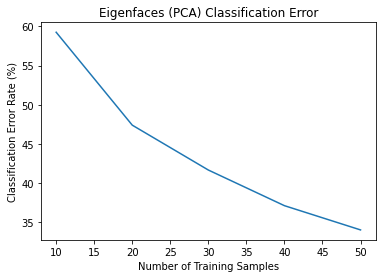

In [ ]:
# plot Classification Error Rate vs Number of Trainings Samples curves
plt.plot(m_values, classification_errors)
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('Eigenfaces (PCA) Classification Error')
plt.show()


In [ ]:
# define range of m values to try
m_values = [10, 20, 30, 40, 50]

# initialize variables to store classification errors for each value of m
classification_errors = []


In [ ]:

# loop over m values
for m in m_values:
    # randomly select m images per individual to form the training set
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for label in np.unique(gnd):
        label_indices = np.where(gnd == label)[0]
        np.random.shuffle(label_indices)
        train_indices = label_indices[:m]
        test_indices = label_indices[m:]
        train_data.append(fea[train_indices])
        train_labels.append(gnd[train_indices])
        test_data.append(fea[test_indices])
        test_labels.append(gnd[test_indices])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # convert training data into vectors
    train_vectors = train_data - train_data.mean(axis=0)

    # compute covariance matrix
    cov_matrix = np.cov(train_vectors.T)

    # compute eigenvectors and eigenvalues of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # sort eigenvectors by decreasing eigenvalue
    sorted_indices = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # select m largest eigenvectors and normalize them
    eigenfaces = eigenvectors[:, :100]
    eigenfaces /= np.linalg.norm(eigenfaces, axis=0)

    # project training data onto eigenfaces
    train_projections = np.dot(train_vectors, eigenfaces)

    # project test data onto eigenfaces
    test_vectors = test_data - train_data.mean(axis=0)
    test_projections = np.dot(test_vectors, eigenfaces)

    # find closest training image for each test image
    train_indices = []
    for i in range(test_data.shape[0]):
        distances = np.linalg.norm(
            train_projections - test_projections[i], axis=1)
        train_indices.append(np.argmin(distances))
    train_indices = np.array(train_indices)

    # predict labels of test images
    predicted_labels = train_labels[train_indices]

    classification_error_rate = np.sum(
        predicted_labels != test_labels) / test_labels.shape[0] * 100

    print(f"Classification Error Rate: {classification_error_rate}")

    # compute classification error rate
    classification_errors.append(classification_error_rate)


Classification Error Rate: 59.34119960668633
Classification Error Rate: 47.15840386940749
Classification Error Rate: 38.775510204081634
Classification Error Rate: 39.261744966442954
Classification Error Rate: 32.295719844357976


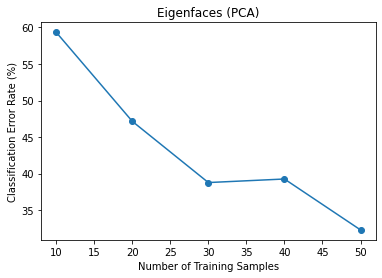

In [ ]:

# plot classification errors vs. number of training samples
plt.plot(m_values, classification_errors, '-o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Classification Error Rate (%)')
plt.title('Eigenfaces (PCA)')
plt.show()
